In [8]:
import os
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.augmentations import Compose
from util.data_aug import *
from transform import MyBoxTransform
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.actions_tree_noscale import Actor
import torch.nn.functional as F
from models.mnist_model import Net, EmbeddingNet, Agent
from datasets.clutter_mnist_rl import MNIST_CoLoc
from RL import get_policy_loss
import matplotlib.ticker as ticker

img_size = 84
num_cls = 5
batch_size = 320
hidden_size = 24
trainfrom = 'simclr'

os.environ['CUDA_VISIBLE_DEVICES']='3'

def convert_image_np(inp, norm=True):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    return inp


In [10]:
def init_dataloader():
    kwargs = {'num_workers': 8, 'pin_memory': True}

    train_transform = Compose([Resize(84)])
    test_transform = Compose([Resize(84)])
    trainset = MNIST_CoLoc(root='.', train=True, digit=4,
                           datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                           clutter=1, transform=train_transform,
                           target_transform=MyBoxTransform(num=1))
    testset = MNIST_CoLoc(root='.', train=False, digit=4,
                          datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                          clutter=1, transform=test_transform,
                          target_transform=MyBoxTransform(num=1))

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader

In [5]:
def init_model(hidden_size, norm, freeze=1):
    embedding_net = EmbeddingNet(norm=norm)
    net = Net(embedding_net, pooling_size=28,
              pooling_mode='align').to(device)
    agent = Agent(dim=1810, num_class=5,
                  hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    pretrained = 'cluttermnist_m60_trip_SGD_proto/best.pth.tar'
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                      'selfpaced/ordinal/',
                      pretrained))
    net.load_state_dict(ckpt['state_dict'])
    print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                                ckpt['epoch'], ckpt['acc']))
    if freeze == 1:
        for name, value in net.named_parameters():
            value.requires_grad = False

    return net, agent


In [21]:
hidden_size = 24
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = init_dataloader()
model, agent = init_model(hidden_size=hidden_size, norm=0)

# load model 
savename = 'coloc_rl_sparse_seq15'
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, savename, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

total train image:  5842  test image:  982
loaded from cluttermnist_m60_trip_SGD_proto/best.pth.tar
ckpt epoch 48 acc 91.65%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/coloc_rl_sparse_seq15/best.pth.tar
=> loaded checkpoint epoch 55 64.25662231445312


In [35]:
# draw arrow 
def draw_arrow(x, y, dx, dy):
    '''
    direction is up/down/left/right
    '''
    plt.arrow(x, y, dx, dy, length_includes_head=True, fc='y',
      head_width=0.08, head_length=0.00002)

/research/cbim/vast/tl601/anaconda3/envs/torch_ml/lib/python3.6/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


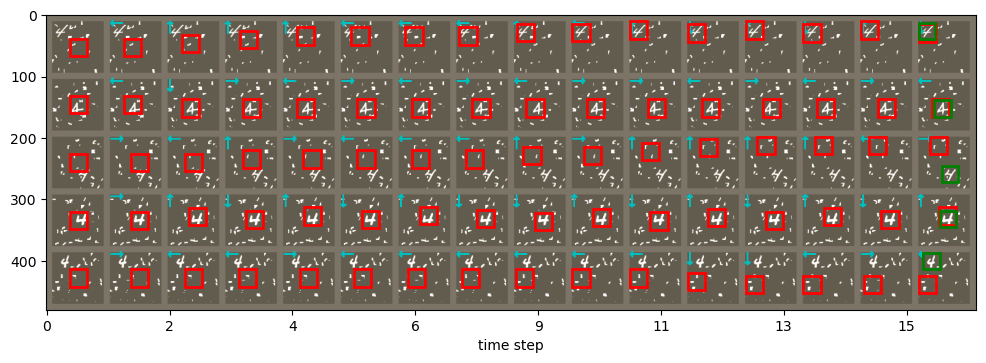

In [66]:
# visualize actions
seq_len = 15
num = 5
batch_size = 512
with torch.no_grad():
    net.eval()
    agent.eval()
    data_org, target_org, ti, pixi = next(iter(train_loader))
    data_org, target_org = data_org.to(device), target_org.to(device).float()
    data, target = data_org[:num], target_org[:num]
    img = convert_image_np(torchvision.utils.make_grid(data.repeat(1, seq_len+1, 1, 1).view(num*(seq_len+1),
                                1, data.shape[2], data.shape[3]).cpu(), nrow=seq_len+1,
                                    padding=10), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    state = data_org.clone()
    all_embed = []
    logits_seq = []
    pred_boxes = torch.tensor([[28,28,56,56]]).float().repeat(batch_size, 1)
    boxes = [pred_boxes]
    rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
    org_boxes = pred_boxes.clone().to(device)
    rois_t0 = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                            target_org.to(device)), dim=1)
    action_seq = torch.IntTensor(batch_size, seq_len).to(device)
    rewards_all = torch.zeros((batch_size, seq_len+1)).to(device)
    actor = Actor(data_org, min_box_side=28)
    if hidden_size:
        h_t = torch.zeros(
            batch_size,
            hidden_size,
            dtype=torch.float,
            device=device,
            requires_grad=True,
        )
    # 1st forward classifier
    with torch.no_grad():
        embed_t = model(data_org, rois_t0)
        embed = model(data_org, rois)
    rewards_all[:, 0] = F.pairwise_distance(embed_t, embed)

    for t in range(seq_len):
        if hidden_size:
            h_t, logits, actions, _ = agent(embed, h_t_prev=h_t)
        else:
            logits, actions, _ = agent(embed)
        state, pred_boxes = actor.takeaction(actions)
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
        with torch.no_grad():
            embed = model(data_org, rois)
        all_embed.append(embed)
        #rewards_all[:, t+1] = F.pairwise_distance(embed_t, embed)
        action_seq[:, t] = actions.view(1, -1)
        logits_seq.append(logits)
        boxes.append(pred_boxes)

    rewards_trns = F.pairwise_distance(embed_t.repeat(seq_len, 1),
                                       torch.cat(all_embed))
    rewards_all[:, 1:] = rewards_trns.view(-1, batch_size).permute(1,0)
    
    for t in range(len(boxes)):
        for i, b in enumerate(boxes[t][:num]): # (num ,4)
            change_y = i * (img_size+10) + 10
            change_x = t * (img_size+10) + 10
            b[1::2] += change_y # change y1, y2
            b[::2] += change_x     # 
            #print('t ', t, ' change_y ', change_y, ' change_x ', change_x)
            
            if t>0:
                if action_seq[i, t-1] == 0:
                    plt.plot(change_x, change_y, 'yo')
                elif action_seq[i,t-1] == 1:
                    plt.arrow(change_x+20, change_y+3, -20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 2:
                    plt.arrow(change_x, change_y+3, 20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 3:
                    plt.arrow(change_x+3, change_y+20, 0, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 4:
                    plt.arrow(change_x+3, change_y, 0, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
            
    
    for i in range(target.shape[0]):
        target[i, 1::2] += i * (img_size+10) + 10
        target[i, ::2]  += seq_len * (img_size+10) + 10
    
    for box in boxes:
        for x1, y1, x2, y2 in box[:num]:
            patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            
    for x1, y1, x2, y2 in target:
        patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='g', facecolor='none', fill=False)
        ax.add_patch(patch)
    
    ax.set_xlabel('time step')
    scale_x = img_size + 10
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    plt.show()

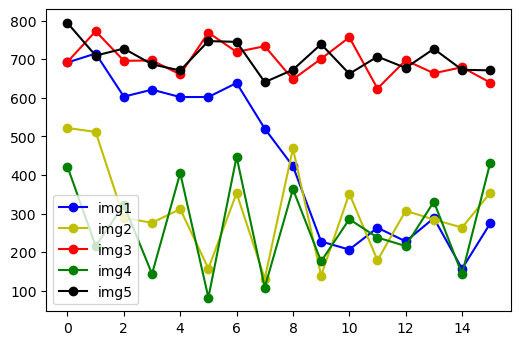

In [67]:
# plot rewards_all, i.e., distance to target
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
for i, r in enumerate(rewards_all[:5].cpu().numpy()):
    plt.plot(range(seq_len+1), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.show()